In [330]:
from citalopram_project.load import load_eeg, load_neurons, load_spikes
from scipy.ndimage import gaussian_filter1d
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm



from citalopram_project.transforms import bin_spikes, bin_spikes_interval
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [316]:
def assign_band(df_fft, freq_col="frequency"):
    """
    Filter freqs between 0 - 8 Hz and assign each freq to 
    delta or theta band
    """
    return (
        df_fft
        .loc[lambda x: (x[freq_col] < 8) & (x[freq_col] > 0)]
        .assign(
            band = lambda x: x[freq_col].apply(lambda y: "delta" if y < 4 else "theta")
        )
    )

def mean_band_psd_ts(
    df_fft, 
    sig_col="signal_name", 
    sesh_col="session_name",
    time_col="timepoint_s",
    group_col="group_name",
    band_col="band",
    psd_col="fft_value"
):
    """
    Create df with one row per timepoint per band and the mean
    power in the band at that timepoint.
    """
    return (
        df_fft
        .groupby([sesh_col, sig_col, time_col, group_col, band_col])
        .apply(lambda x: np.mean(x[psd_col]))
        .reset_index()
        .rename(columns={0: "psd"})
        .pivot_table(index=[sesh_col, time_col], columns=band_col, values="psd")
        .reset_index()
        .assign(
            delta_smooth= lambda x: gaussian_filter1d(x.delta, 5),
            theta_smooth= lambda x: gaussian_filter1d(x.theta, 5),
            delta_to_theta = lambda x: x.delta / x.theta,
            delta_to_theta_smooth = lambda x: x.delta_smooth / x.theta_smooth
               )
        .rename(columns={time_col: "time"})
        .assign(time=lambda x: x["time"] - 2)
    )

def _neuron_eeg_corr_session(spikes_session, band_session, eeg_col="delta_to_theta_smooth"):
    merged = spikes_session.pivot(index="time", columns="neuron_id", values="spike_count").join(band_session.set_index("time")[eeg_col])
    to_corr = merged[eeg_col]
    res = (
        merged.drop(eeg_col, axis=1)
        .apply(lambda x: x.corr(to_corr))
        .reset_index()
        .rename(columns={0: "eeg_corr", "index": "neuron_id"})
    )
    return res

def get_neuron_eeg_corr(spikes, band_ts, eeg_col, session_col="session_name"):
    dfs = []
    for session in spikes[session_col].unique():
        # print(session)
        band_session = band_ts.loc[lambda x: x[session_col] == session]
        spikes_session = spikes.loc[lambda x: x[session_col] == session]
        spikes_session = bin_spikes_interval(df=spikes_session, bin_width=2, t_start=0)

        df_res = _neuron_eeg_corr_session(spikes_session, band_session, eeg_col=eeg_col)
        dfs.append(df_res.assign(**{session_col: session}))
    return pd.concat(dfs).reset_index(drop=True)

def compare(df, value_col, group_col="group", groups=("sal", "continuation")):
    out = dict()
    x = df.loc[lambda x: x[group_col] == groups[0]][value_col]
    y = df.loc[lambda x: x[group_col] == groups[1]][value_col]
    out[f"n {groups[0]}"] = len(x)
    out[f"n {groups[1]}"] =len(y)
    out[f"m {groups[0]}"] = np.median(x)
    out[f"m {groups[1]}"] =np.median(y)
    out["U"], out["p"] = mannwhitneyu(x, y)
    out["p"] = round(out["p"], 3)
    return pd.Series(out)

In [323]:
# df_eeg = load_eeg("pre")

df_fft = assign_band(df_eeg)
band_ts = mean_band_psd_ts(df_fft)
neurons = load_neurons()[["neuron_id", "session_name", "group", "cluster"]].loc[lambda x: x.group != "discontinuation"]
spikes = load_spikes("pre").merge(neurons)
df_res = get_neuron_eeg_corr(spikes, band_ts, eeg_col="delta_to_theta", session_col="session_name").merge(neurons).dropna()

In [340]:

mod = smf.ols("abs_eeg_corr ~ cluster * group", data=df_res).fit()
anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
cluster,2.0,0.001183,0.000592,0.042239,0.958648
group,1.0,0.058391,0.058391,4.169419,0.042158
cluster:group,2.0,0.001830,0.000915,0.065343,0.936761
Residual,263.0,3.683201,0.014005,NaN,NaN


In [342]:
mod = smf.ols("abs_eeg_corr ~ group", data=df_res).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           abs_eeg_corr   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.261
Date:                Fri, 20 May 2022   Prob (F-statistic):             0.0400
Time:                        15:04:16   Log-Likelihood:                 195.34
No. Observations:                 269   AIC:                            -386.7
Df Residuals:                     267   BIC:                            -379.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1808      0.010     18.534      0.000       0.162       0.200
group[T.sal]    -0.0297      0.014     -2.064      0.040      -0.058      -0.001
==============================================================================
Omnibus:                       16.805   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.958
Skew:                           0.571   Prob(JB):                     0.000208
Kurtosis:                       2.544   Cond. No.                         2.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

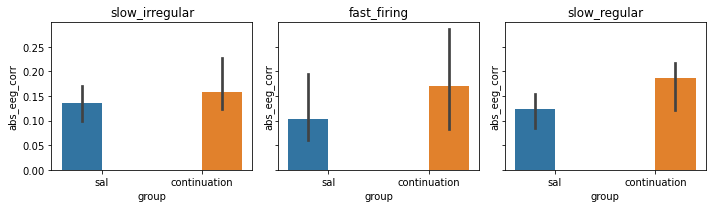

In [329]:
_, axes = plt.subplots(ncols=3, figsize=(10, 3), sharey=True)

for i, cluster in enumerate(df_res["cluster"].unique()):
    sns.barplot(data=df_res.loc[lambda x: x.cluster == cluster], x="group", hue="group", y="abs_eeg_corr", ax=axes[i], estimator=np.median)
    axes[i].set_title(cluster)
    axes[i].get_legend().remove()


plt.tight_layout()

n sal              124.000000
n continuation     145.000000
m sal                0.127220
m continuation       0.171135
U                 7690.000000
p                    0.021000
dtype: float64


<AxesSubplot:xlabel='group', ylabel='abs_eeg_corr'>

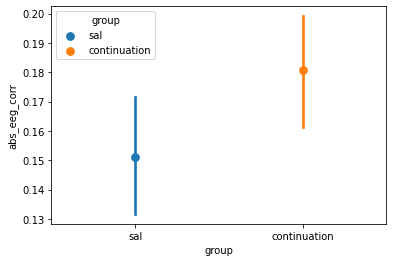

In [345]:
df_res["abs_eeg_corr"] = df_res["eeg_corr"].abs()

print(compare(df_res, "abs_eeg_corr"))

sns.pointplot(data=df_res, x="group", y="abs_eeg_corr", hue="group")

In [ ]:
df_res.groupby("cluster").apply(lambda x: compare(x, "abs_eeg_corr"))

In [346]:
from citalopram_project.load import get_data_dir
derived_data_dir = get_data_dir() / "derived"

df_res.to_csv(derived_data_dir / "eeg_corr.csv", index=False)

In [151]:
spikes_session = spikes.loc[lambda x: x.session_name == "hamilton_01"]

bin_spikes_interval(df=spikes_session, bin_width=2, t_start=0)

,neuron_id,time,spike_count
0,1069,0.0,19
1,1069,2.0,16
2,1069,4.0,10
3,1069,6.0,12
4,1069,8.0,6
...,...,...,...
15312,1087,1792.0,0
15313,1087,1794.0,4
15314,1087,1796.0,3
15315,1087,1798.0,0


In [146]:
band_ts.loc[lambda x: x.session_name == "hamilton_01"]

band,session_name,time,delta,theta,delta_smooth,theta_smooth,delta_to_theta,delta_to_theta_smooth
5434,hamilton_01,0.0,14.573425,2.100514,30.342845,7.944753,6.938027,3.819230
5435,hamilton_01,2.0,26.727093,1.837623,29.692174,7.443933,14.544382,3.988775
5436,hamilton_01,4.0,14.942654,1.771455,29.063183,6.952950,8.435245,4.179979
5437,hamilton_01,6.0,20.481296,2.163144,28.464306,6.476367,9.468299,4.395104
5438,hamilton_01,8.0,25.031480,2.375249,27.902843,6.018510,10.538465,4.636171
...,...,...,...,...,...,...,...,...
6329,hamilton_01,1790.0,8.248647,1.431826,17.437828,2.240466,5.760927,7.783126
6330,hamilton_01,1792.0,5.356082,1.139176,18.120699,2.228493,4.701718,8.131368
6331,hamilton_01,1794.0,5.699604,0.952346,18.815941,2.210871,5.984805,8.510646
6332,hamilton_01,1796.0,8.079460,1.727373,19.517735,2.188117,4.677310,8.919878


In [147]:
band_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   session_name           16241 non-null  object 
 1   time                   16241 non-null  float64
 2   delta                  16241 non-null  float64
 3   theta                  16241 non-null  float64
 4   delta_smooth           16241 non-null  float64
 5   theta_smooth           16241 non-null  float64
 6   delta_to_theta         16241 non-null  float64
 7   delta_to_theta_smooth  16241 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1015.2+ KB


In [104]:
band_ts.loc[lambda x: x.session_name == "hamilton_01"]

band,session_name,time,delta,theta,delta_smooth,theta_smooth,delta_to_theta,delta_to_theta_smooth
5434,hamilton_01,0.0,14.573425,2.100514,30.342845,7.944753,6.938027,3.819230
5435,hamilton_01,2.0,26.727093,1.837623,29.692174,7.443933,14.544382,3.988775
5436,hamilton_01,4.0,14.942654,1.771455,29.063183,6.952950,8.435245,4.179979
5437,hamilton_01,6.0,20.481296,2.163144,28.464306,6.476367,9.468299,4.395104
5438,hamilton_01,8.0,25.031480,2.375249,27.902843,6.018510,10.538465,4.636171
...,...,...,...,...,...,...,...,...
6329,hamilton_01,1790.0,8.248647,1.431826,17.437828,2.240466,5.760927,7.783126
6330,hamilton_01,1792.0,5.356082,1.139176,18.120699,2.228493,4.701718,8.131368
6331,hamilton_01,1794.0,5.699604,0.952346,18.815941,2.210871,5.984805,8.510646
6332,hamilton_01,1796.0,8.079460,1.727373,19.517735,2.188117,4.677310,8.919878


In [29]:
for session in spikes["session_name"].unique():
    spikes_session = spikes.loc[lambda x: x.session_name == session]
    eeg_session = band_ts.loc[]

band,session_name,timepoint_s,delta,theta,delta_smooth,theta_smooth,delta_to_theta,delta_to_theta_smooth
0,chronic_01,2.0,3.952869,2.756887,11.843264,4.262615,1.433816,2.778403
1,chronic_01,4.0,4.254086,2.634177,11.885809,4.275969,1.614959,2.779676
2,chronic_01,6.0,17.741965,4.137431,11.969551,4.302439,4.288160,2.782039
3,chronic_01,8.0,6.864337,2.959577,12.091705,4.341374,2.319364,2.785225
4,chronic_01,10.0,9.274137,3.820085,12.248260,4.391951,2.427731,2.788797
...,...,...,...,...,...,...,...,...
16236,hamilton_20,1792.0,19.268710,6.290477,13.521231,3.137569,3.063156,4.309461
16237,hamilton_20,1794.0,11.771309,1.924300,13.441134,3.130739,6.117189,4.293278
16238,hamilton_20,1796.0,7.733123,2.071034,13.375334,3.124602,3.733944,4.280652
16239,hamilton_20,1798.0,7.946130,1.649786,13.328605,3.120014,4.816460,4.271969


<AxesSubplot:>

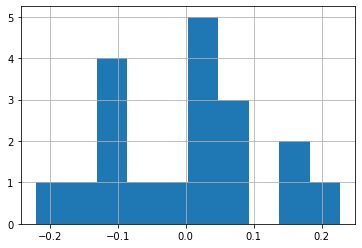

In [52]:
(
    spikes
    .loc[lambda x: x.session_name == "chronic_01"]
    .pivot(index="time", columns="neuron_id", values="spike_count")
    .loc[lambda x: x.index.isin(band_session["time"].values)]
    .apply(lambda x: x.corr(band_session["delta_to_theta"]))
    .reset_index()
    .rename(columns={0: "eeg_corr"})
    ["eeg_corr"]
    .hist()
)

In [51]:
band_session = band_ts.loc[lambda x: x.session_name == "chronic_01"]

In [44]:
band_session["time"].values

array([2.000e+00, 4.000e+00, 6.000e+00, ..., 3.596e+03, 3.598e+03,
       3.600e+03])

In [ ]:
band_ts.rename